In [2]:
# 파일 저장 커스텀 모듈

import sys
sys.path.append("../custom")

from importlib import reload
import custom_utils
reload(custom_utils)

from custom_utils import save_var, load_var


In [3]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


# 1. Tokenizer 준비

SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만드세요.

이를 위해 한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만들어 보세요.  
BERT에 사용되는 주요 특수문자가 vocab에 포함되어야 합니다.  
(시간이 부족하다면 클라우드에 저장된 sentencepiece 모델을 사용하세요.)

In [73]:
# 실행하길 원한다면 """ 를 지워주세요.
import sentencepiece as spm
import os
corpus_file = 'data/kowiki.txt'
prefix = 'ko_8k'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=data/kowiki.txt --model_prefix=ko_800 --vocab_size=8007 --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/kowiki.txt
  input_format: 
  model_prefix: ko_800
  model_type: BPE
  vocab_size: 8007
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [SEP]
  user_defined_symbols: [CLS]
  us

In [74]:
# vocab loading
vocab = spm.SentencePieceProcessor()

In [75]:
# data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
# model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'
data_dir = 'data'
model_dir ='models'

# vocab.load(f"{model_dir}/ko_32000.model")
vocab.load(f"{model_dir}/ko_8k.model")

True

# 2. 데이터 전처리 (1) MASK 생성

BERT의 MLM에 필요한 빈칸(mask)을 학습 데이터 전체 토큰의 15% 정도로 만들어 주세요.   
- [x] 그 중 80%는 [MASK] 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용하세요.

In [88]:
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_mask(tokens, mask_cnt, vocab_list, verbose=False):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    
    if verbose: 
        print(f"tokens length: {len(tokens)}")
        print(f"tokens: \n{tokens}\n")
    
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    if verbose: print(f"cand_idx: {cand_idx}")
        
    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)
    
    if verbose:
        print(f"can_idx length: {len(cand_idx)}")
        print(f"cand_idx: {cand_idx}")
    
    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
              break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
              continue
        dice = random.random()  # 0과 1 사이의 확률 값

        if verbose:
            print(f"index_set: {index_set}")
            print(f"dice: {dice}")

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
                
            if verbose:
                print(f"masked_token: {masked_token}")
                print(f"index: {index}")
                
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token


    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  
    mask_label = [p["label"] for p in mask_lms] 

    return tokens, mask_idx, mask_label

> class Preprocessor 에서 구현

# 3. 데이터 전처리 (2) NSP pair 생성

BERT의 pretrain task인 NSP는 두 문장이 연속하는지 확인하는 것입니다.  

- [x] 이를 위해 2개의 문장을 짝지어 50%의 확률로 TRUE와 FALSE를 지정해 주세요.
- [x] 두 문장 사이에 segment 처리를 해주세요.   
- [x] 첫 번째 문장의 segment는 0, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주세요.  

MLM과 NSP는 동시에 학습된다는 것을 염두에 두고 학습 데이터를 구성해 보세요.

In [93]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [89]:
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])

            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1

            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

> class Preprocessor 에서 구현

# 4. 데이터 전처리 (3) 데이터셋 완성

BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요.  

In [30]:
class Preprocessor:
    def __init__(self, vocab, corpus_filepath, pretrain_filepath, 
                 n_seq=64, min_seq=8, max_mask=0.15,
                 verbose=False):
        """
        :param vocab: vocab (sentencepiece)
        :param corpus_filepath: input file path
        :parm pretrain_filepath: output json file path
        :param n_seq
        :param min_seq
        :param max_mask
        """
        self.vocab = vocab
        self.make_vocab_list()
        
        self.n_seq = n_seq
        self.min_seq = min_seq
        self.max_seq = n_seq - 3

        self.corpus_filepath = corpus_filepath
        self.pretrain_filepath = pretrain_filepath
        
        self.max_mask = max_mask
        
        self.verbose = verbose
        
        if self.verbose:
            print(self.vocab)
            print(self.n_seq)
            print(self.min_seq)
            print(self.max_seq)
            print(self.corpus_filepath)
            print(self.pretrain_filepath)
            print(self.max_mask)
            print(self.verbose)
            
        self.make_pretrain_data()

        
    def make_vocab_list(self):
        """특수문자 7개를 제외한 vocab_list 생성"""
        self.vocab_list = []
        for id in range(7, len(self.vocab)):
            if not self.vocab.is_unknown(id):  # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
                self.vocab_list.append(vocab.id_to_piece(id))
        

    def split_into_chunks(self, doc):
        """문서를 문장으로 나누기"""
        chunks = []
        current_chunk = []
        current_length = 0

        for line in doc:
            current_chunk.append(line)
            current_length += len(line)

            if len(current_chunk) > 1 and (current_length >= self.max_seq or line == doc[-1]):
                chunks.append(current_chunk[:])
                current_chunk.clear()
                current_length = 0

        return chunks

    
    def swap_tokens(self, chunk):
        """토큰 교환"""
        a_end = random.randrange(1, len(chunk)) if len(chunk) > 1 else 1

        tokens_a = [token for sublist in chunk[:a_end] for token in sublist]
        tokens_b = [token for sublist in chunk[a_end:] for token in sublist]

        #  2개의 문장을 짝지어 50%의 확률로 TRUE와 FALSE를 지정
        if random.random() < 0.5:
            tokens_a, tokens_b = tokens_b, tokens_a
            is_next = 0
        else:
            is_next = 1

        return tokens_a, tokens_b, is_next
    

    def create_instance(self, tokens_a, tokens_b, is_next):
        """토큰 생성"""
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
        segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

        max_mask = int((len(tokens) - 3) * self.max_mask)  # mask 개수 (전체 tokens의 15%)
        tokens, mask_idx, mask_label = self.create_pretrain_mask(tokens)

        instance = {
            "tokens": tokens,
            "segment": segment,
            "is_next": is_next,
            "mask_idx": mask_idx,
            "mask_label": mask_label
        }
        return instance
    

    def preprocess_doc(self, doc):
        """문서 처리
        :param doc: 문서
        :return instances
        """
        instances = []
        chunks = self.split_into_chunks(doc)

        for chunk in chunks:
            tokens_a, tokens_b, is_next = self.swap_tokens(chunk)
            self.trim_tokens(tokens_a, tokens_b)

            instance = self.create_instance(tokens_a, tokens_b, is_next)
            instances.append(instance)

        return instances

                
    def trim_tokens(self, tokens_a, tokens_b):
        """
        tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
        :param tokens_a: tokens A
        :param tokens_b: tokens B
        :param max_seq: 두 tokens 길이의 최대 값
        """
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= self.max_seq:
                break

            if len(tokens_a) > len(tokens_b):
                del tokens_a[0]
            else:
                tokens_b.pop()
                
    def create_pretrain_mask(self, tokens):
        """
        마스크 생성
        :param tokens: tokens
        :return tokens: mask된 tokens
        :return mask_idx: mask된 token의 index
        :return mask_label: mask된 token의 원래 값
        """

        if self.verbose: 
            print(f"tokens length: {len(tokens)}")
            print(f"tokens: \n{tokens}\n")

        # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
        cand_idx = []  # word 단위의 index array
        for (i, token) in enumerate(tokens):

            if self.verbose: print(f"token {i:2}: {token}")

            if token == "[CLS]" or token == "[SEP]":
                continue
            if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
                cand_idx[-1].append(i)
            else:
                cand_idx.append([i])

        if self.verbose: print(f"cand_idx: {cand_idx}")

        # random mask를 위해서 순서를 섞음 (shuffle)
        random.shuffle(cand_idx)

        if self.verbose:
            print(f"can_idx length: {len(cand_idx)}")
            print(f"cand_idx: {cand_idx}")

        mask_lms = []  # mask 된 값
        for index_set in cand_idx:
            # 현재 mask된 개수가 15%를 넘으면 중지
            if len(mask_lms) >= self.max_mask:
                  break
            # 이번에 mask할 개수를 포함해 max_mask(15%)를 넘으면 skip
            if len(mask_lms) + len(index_set) > self.max_mask:
                  continue
            dice = random.random()  # 0과 1 사이의 확률 값

            if self.verbose:
                print(f"index_set: {index_set}")
                print(f"dice: {dice}")

            for index in index_set:
                masked_token = None
                
                #  80%는 [MASK] 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용
                if dice < 0.8:  # 80% replace with [MASK]
                    masked_token = "[MASK]"
                elif dice < 0.9: # 10% keep original
                    masked_token = tokens[index]
                else:  # 10% random word
                    masked_token = random.choice(self.vocab_list)

                if self.verbose:
                    print(f"masked_token: {masked_token}")
                    print(f"index: {index}")

                mask_lms.append({"index": index, "label": tokens[index]})
                tokens[index] = masked_token


        # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
        mask_lms = sorted(mask_lms, key=lambda x: x["index"])
        mask_idx = [p["index"] for p in mask_lms]  
        mask_label = [p["label"] for p in mask_lms] 

        return tokens, mask_idx, mask_label
    
    def save_pretrain_instances(self, out_f, doc):
        """ pretrain 데이터 생성 """
        instances = self.preprocess_doc(doc)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    def make_pretrain_data(self):
        """pretrain 데이터셋 생성"""
                
        # line count 확인
        line_cnt = 0
        with open(self.corpus_filepath, "r") as in_f:
            for line in in_f:
                line_cnt += 1

        with open(self.corpus_filepath, "r") as in_f:
            with open(self.pretrain_filepath, "w") as out_f:
                doc = []
                for line in tqdm(in_f, total=line_cnt):
                    line = line.strip()
                    if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                        if 0 < len(doc):
                            self.save_pretrain_instances(out_f, doc)
                            doc = []
                    else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                        pieces = self.vocab.encode_as_pieces(line)
                        if 0 < len(pieces):
                            doc.append(pieces)
                if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                    save_pretrain_instances(out_f, doc)
                    doc = []


In [24]:
corpus_filepath = 'data/kowiki.txt'
pretrain_filepath = 'data/bert_pre_train_8k.json'

In [76]:
preprocessor = Preprocessor(vocab, corpus_filepath, pretrain_filepath, max_mask=0.15)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [77]:
with open(pretrain_filepath, "r") as in_f:
    line_cnt = 0
    for line in in_f:
        line_cnt += 1
        print(line)
        if line_cnt > 10:
            break

{"tokens": ["[CLS]", "▁주", "니어", "(,", "▁192", "4", "년", "▁10", "월", "▁1", "일", "▁~", "▁)", "는", "▁민주", "당", "▁출신", "▁미국", "▁3", "9", "번째", "▁대통령", "▁(19", "7", "7", "년", "▁~", "▁1981", "년", ")", "이다", ".", "[SEP]", "▁지", "미", "▁카", "터", "는", "▁조지", "아", "주", "▁섬", "터", "▁카운", "티", "▁플", "레", "인", "스", "▁마을", "에서", "▁태어났다", ".", "▁조지", "아", "▁공", "과", "대학교", "를", "▁졸업", "하였다", ".", "▁그", "[SEP]"], "segment": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "is_next": 1, "mask_idx": [], "mask_label": []}

{"tokens": ["[CLS]", ",", "▁1971", "년부터", "▁1975", "년까지", "▁조지", "아", "▁지", "사로", "▁근무", "했다", ".", "▁조지", "아", "▁주", "지", "사로", "▁지", "내", "면서", ",", "▁미국", "에", "▁사는", "▁흑", "인", "▁등", "용", "법을", "▁내", "세", "웠다", ".", "[SEP]", "▁1976", "년", "▁대통령", "▁선거", "에", "▁민주", "당", "▁후보", "로", "▁출", "마", "하여", "▁도", "덕", "주의", "▁정책", "으로", "▁내", "세", 

In [90]:
# Q. 아래 주석에 따라 코드를 완성해주세요.
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

In [94]:
pretrain_filepath = 'data/bert_pre_train_8k_made.json'
make_pretrain_data(vocab, corpus_file, pretrain_filepath, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

데이터셋의 사이즈가 크므로 np.memmap 을 사용해 메모리 사용량을 최소화해 보세요.

In [95]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.full(n_seq, dtype=np.int32, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [96]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_filepath, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

data load early stop 128000 128000


In [97]:
prefix = "t3"

In [98]:
save_var(pre_train_inputs, f"pre_train_inputs_8k_{prefix}")
save_var(pre_train_labels, f"pre_train_labels_8k_{prefix}")

In [99]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_labels[0][0], pre_train_labels[0][-1]

(memmap([   5,   18, 3686,  207, 3714, 3324, 1042,  103, 3610, 3686, 3718,
         7962, 1488,   37, 3418,  416,  810, 3666, 3625,  131, 3662,    7,
         3629,  203,  241, 3602, 1114, 3724,  788,  243,   49, 3632,  796,
          663, 1647, 3682, 3682, 3625,  203, 3008, 3625, 3616,   16, 3599,
            4,   18, 3686,  207, 3714, 3602, 1755, 3630, 3646,  630, 3714,
         3565, 3835,  429, 3740, 3628, 3626,    6,    6, 1605, 3599, 1755,
         3630,   41, 3644,  830, 3624, 1135,   52, 3599,   13,   81,   87,
         1501, 2247,   25, 3779, 3873, 3667, 3631, 3813, 3873, 4196, 3636,
         3779, 3601,    6,    6,    6,   33,   52, 3599,  479, 3652, 3625,
          243, 2780,   14, 1509,    6,    6,    6,  165, 1697, 4290, 3873,
         3703, 3683,  593, 6186,  798,  399, 1927, 3607,    6,    6,    6,
          307,  587,  931,  103, 4313, 4290,    4], dtype=int32),
 memmap([   5,   13,   81, 3604,   15, 3784,    6,    6,    6,   13,  316,
            6,    6,  305, 3620, 1

# 5. BERT 모델 구현

pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.

Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, pretraine용 BERT 모델을 만들어 봅시다.

## utility

In [40]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


In [41]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

In [42]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


In [43]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)


## embedding layers

In [44]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs


In [45]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed


# attention

In [46]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out


In [47]:
# Q. 주석과 코드를 참조하여 아래 클래스를 완성해주세요.
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)

        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)
        
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])
        attn_out = self.W_O(attn_out)
        
        return attn_out


## encoder layer

In [48]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val


In [49]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out


## bert

In [50]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed


In [51]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs


In [52]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model


## build

In [100]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

In [54]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

In [72]:
test_model = build_model_pre_train(config)
test_model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=["acc"])

test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 3s 11ms/step - loss: 9.7524 - nsp_loss: 0.7320 - mlm_loss: 9.0204 - nsp_acc: 0.3000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 10ms/step - loss: 8.5926 - nsp_loss: 0.6302 - mlm_loss: 7.9624 - nsp_acc: 0.9000 - mlm_acc: 0.0000e+00


# 6. pretrain 진행

loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후, 10 Epoch까지 모델 학습을 시켜보세요.  
학습을 진행할 때는 배치 사이즈에 유의하세요.

In [55]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴


In [56]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy


In [57]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr


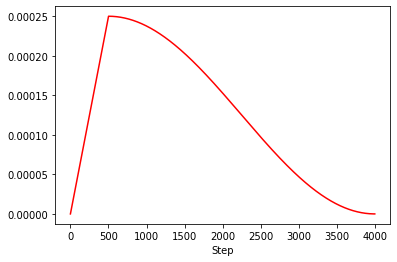

In [58]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [101]:
# 모델 생성
pretrain_model = build_model_pre_train(config)
pretrain_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 4485632     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                 

In [102]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pretrain_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


In [103]:
model_name = f"bert_pretrain_8k_{prefix}"

In [104]:
# Q. 모델을 학습시키고, 내용을 history에 담아주세요.
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(
    f"{model_dir}/{model_name}.hdf5", 
    monitor="mlm_lm_acc", 
    verbose=1, 
    save_best_only=True, 
    mode="max", 
    save_freq="epoch", 
    save_weights_only=True)

In [105]:
# train
# 모델 인자에는 inputs, labels, epochs, batch size, callback 이 필요해요.
history = pretrain_model.fit(
    pre_train_inputs, 
    pre_train_labels, 
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=[save_weights])

Epoch 1/10
2000/2000 [==============================] - 249s 123ms/step - loss: 19.5875 - nsp_loss: 0.6514 - mlm_loss: 18.9361 - nsp_acc: 0.5901 - mlm_lm_acc: 0.1099

Epoch 00001: mlm_lm_acc improved from -inf to 0.10994, saving model to models/bert_pretrain_8k_t3.hdf5
Epoch 2/10
2000/2000 [==============================] - 247s 123ms/step - loss: 17.5616 - nsp_loss: 0.6231 - mlm_loss: 16.9385 - nsp_acc: 0.6183 - mlm_lm_acc: 0.1293

Epoch 00002: mlm_lm_acc improved from 0.10994 to 0.12932, saving model to models/bert_pretrain_8k_t3.hdf5
Epoch 3/10
2000/2000 [==============================] - 247s 123ms/step - loss: 16.3799 - nsp_loss: 0.6149 - mlm_loss: 15.7650 - nsp_acc: 0.6287 - mlm_lm_acc: 0.1451

Epoch 00003: mlm_lm_acc improved from 0.12932 to 0.14509, saving model to models/bert_pretrain_8k_t3.hdf5
Epoch 4/10
2000/2000 [==============================] - 247s 123ms/step - loss: 14.3533 - nsp_loss: 0.6127 - mlm_loss: 13.7406 - nsp_acc: 0.6317 - mlm_lm_acc: 0.1839

Epoch 00004: mlm_

In [106]:
pretrain_model.save_weights(f"{model_name}")

In [92]:
pretrain_model.load_weights(f"{model_name}")

In [101]:
histories = {}

In [107]:
histories[prefix] = history.history

In [108]:
save_var(histories, "histories")

In [67]:
histories = load_var("histories")

# 7. 프로젝트 결과

학습된 모델과 학습과정을 시각화해 보세요.  
NSP와 MLM의 loss가 안정적으로 수렴하나요?  
모델이 작기 때문에 loss가 잘 수렴하지 않을 수도 있어요.

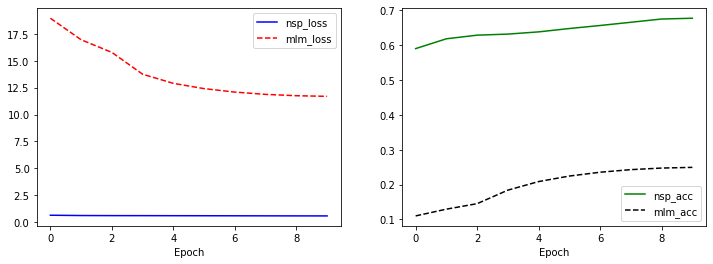

In [109]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# 평가문항 - 상세기준

1. 한글 코퍼스를 가공하여 BERT pretrain용 데이터셋을 잘 생성하였다.	
> MLM, NSP task의 특징이 잘 반영된 pretrain용 데이터셋 생성과정이 체계적으로 진행되었다.
2. 구현한 BERT 모델의 학습이 안정적으로 진행됨을 확인하였다.	
> 학습진행 과정 중에 MLM, NSP loss의 안정적인 감소가 확인되었다.
3. 1M짜리 mini BERT 모델의 제작과 학습이 정상적으로 진행되었다.	
> 학습된 모델 및 학습과정의 시각화 내역이 제출되었다.